# Importación de dependencias

In [1]:
# Bloque 1: Instalación e Importación de Librerías
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings('ignore')

print("✅ Librerías instaladas e importadas correctamente")

2025-09-26 19:29:31.443234: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-09-26 19:29:31.476861: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-26 19:29:32.394895: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-26 19:29:37.168222: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To tur

✅ Librerías instaladas e importadas correctamente


# Recolección y Procesamiento de Datos

📊 Descargando datos históricos del dólar...


[*********************100%***********************]  1 of 1 completed


📈 Datos obtenidos: 4086 registros
Price             Close         High          Low         Open   Volume
Ticker         USDCOP=X     USDCOP=X     USDCOP=X     USDCOP=X USDCOP=X
Date                                                                   
2025-09-22  3898.899902  3898.899902  3836.110107  3898.899902        0
2025-09-23  3851.199951  3851.199951  3828.449951  3851.199951        0
2025-09-24  3860.250000  3896.679932  3849.159912  3860.250000        0
2025-09-25  3885.239990  3905.199951  3880.969971  3885.239990        0
2025-09-26  3900.250000  3917.590088  3884.750000  3900.250000        0


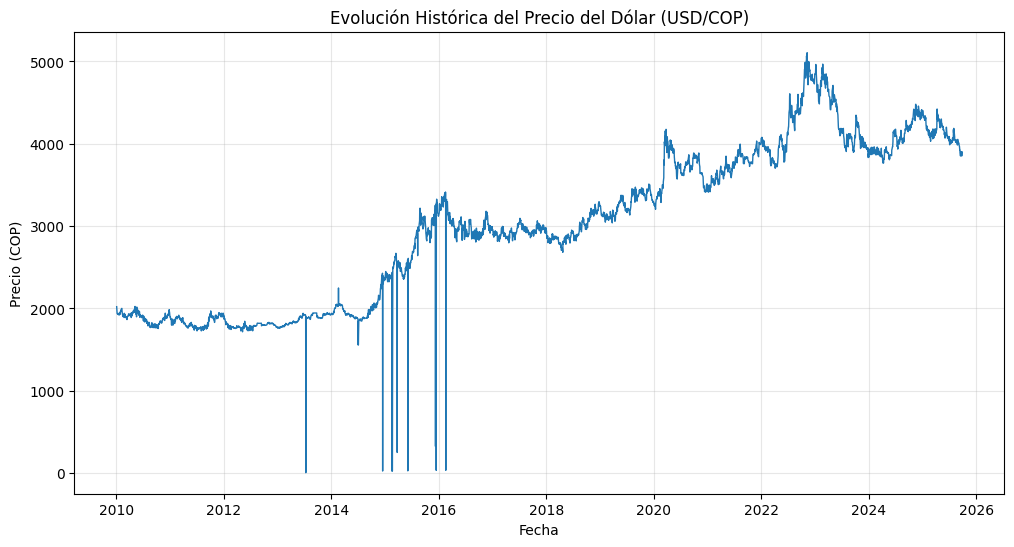

In [2]:
# Bloque 2: Recolección y Procesamiento de Datos
def obtener_datos_historicos():
    """
    Obtiene datos históricos del precio del dólar (USD/COP)
    """
    try:
        # Descargar datos de USD/COP (Peso Colombiano)
        datos = yf.download('USDCOP=X', start='2010-01-01', end=pd.Timestamp.today().strftime('%Y-%m-%d'))
        return datos
    except Exception as e:
        print(f"Error descargando datos: {e}")
        # Datos de ejemplo en caso de error
        return crear_datos_ejemplo()

def crear_datos_ejemplo():
    """
    Crea datos de ejemplo si no se pueden obtener datos reales
    """
    fecha_rango = pd.date_range(start='2010-01-01', end=pd.Timestamp.today(), freq='D')
    np.random.seed(42)
    
    # Crear tendencia base con ruido
    tendencia = np.linspace(2000, 4000, len(fecha_rango))
    ruido = np.random.normal(0, 50, len(fecha_rango))
    precios = tendencia + ruido
    
    datos = pd.DataFrame({
        'Open': precios + np.random.normal(0, 10, len(fecha_rango)),
        'High': precios + np.random.normal(10, 15, len(fecha_rango)),
        'Low': precios - np.random.normal(10, 15, len(fecha_rango)),
        'Close': precios,
        'Volume': np.random.randint(1000000, 5000000, len(fecha_rango))
    }, index=fecha_rango)
    
    return datos

def preparar_datos_secuenciales(datos, dias_entrada=5, dias_salida=7):
    """
    Prepara los datos en secuencias para el modelo
    """
    # Usar el precio de cierre
    precios = datos['Close'].values
    
    X, y = [], []
    
    for i in range(len(precios) - dias_entrada - dias_salida):
        # 5 días de entrada
        secuencia_entrada = precios[i:i + dias_entrada]
        # Precio 7 días después
        precio_salida = precios[i + dias_entrada + dias_salida - 1]
        
        X.append(secuencia_entrada)
        y.append(precio_salida)
    
    return np.array(X), np.array(y)

# Ejecutar recolección de datos
print("📊 Descargando datos históricos del dólar...")
datos_dolar = obtener_datos_historicos()

print(f"📈 Datos obtenidos: {len(datos_dolar)} registros")
print(datos_dolar.tail())

# Visualizar datos
plt.figure(figsize=(12, 6))
plt.plot(datos_dolar.index, datos_dolar['Close'], linewidth=1)
plt.title('Evolución Histórica del Precio del Dólar (USD/COP)')
plt.xlabel('Fecha')
plt.ylabel('Precio (COP)')
plt.grid(True, alpha=0.3)
plt.show()

# Preparación de Datos para el Modelo

📊 Descargando datos históricos del dólar...


[*********************100%***********************]  1 of 1 completed


✅ Datos reales descargados correctamente
📈 Datos obtenidos: 1495 registros
Primeros 5 registros:
Price             Close         High          Low         Open   Volume
Ticker         USDCOP=X     USDCOP=X     USDCOP=X     USDCOP=X USDCOP=X
Date                                                                   
2020-01-01  3279.760010  3279.760010  3279.760010  3279.760010        0
2020-01-02  3279.760010  3281.080078  3241.714111  3279.760010        0
2020-01-03  3252.750000  3266.750000  3252.469971  3252.750000        0
2020-01-06  3256.899902  3253.560059  3245.520020  3252.250000        0
2020-01-07  3244.459961  3262.600098  3202.010742  3244.459961        0

Últimos 5 registros:
Price             Close         High          Low         Open   Volume
Ticker         USDCOP=X     USDCOP=X     USDCOP=X     USDCOP=X USDCOP=X
Date                                                                   
2025-09-22  3898.899902  3898.899902  3836.110107  3898.899902        0
2025-09-23  3851.

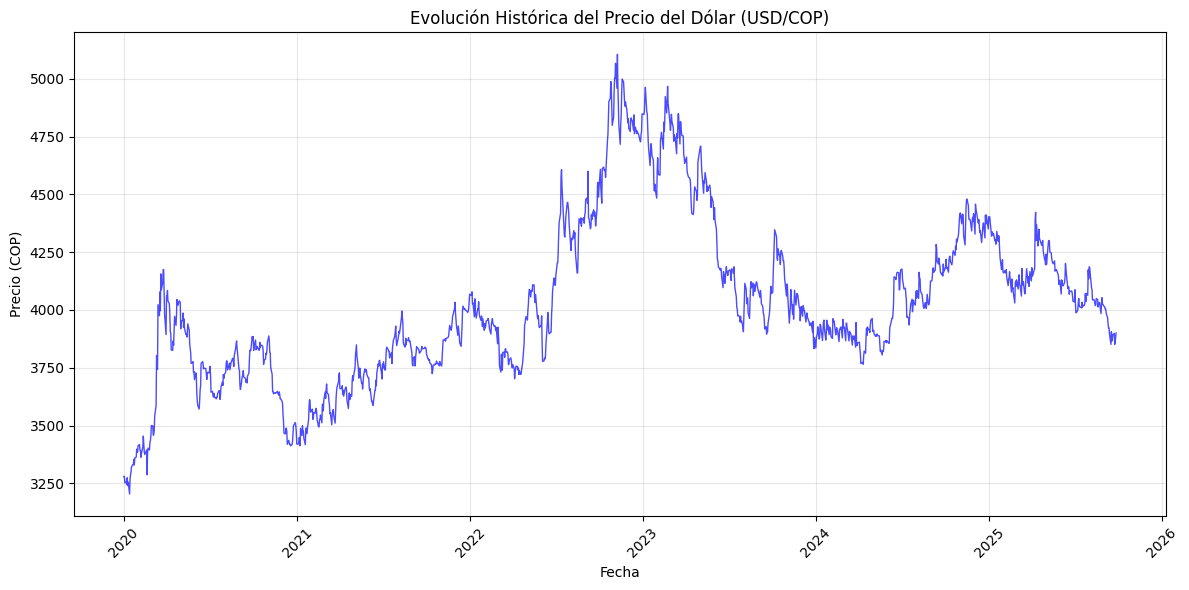

In [4]:
# Bloque 2 Corregido: Recolección y Procesamiento de Datos
def obtener_datos_historicos():
    """
    Obtiene datos históricos del precio del dólar (USD/COP)
    """
    try:
        # Descargar datos de USD/COP (Peso Colombiano)
        datos = yf.download('USDCOP=X', start='2020-01-01', end=pd.Timestamp.today().strftime('%Y-%m-%d'))
        print("✅ Datos reales descargados correctamente")
        return datos
    except Exception as e:
        print(f"⚠️ Error descargando datos reales: {e}")
        print("📋 Usando datos de ejemplo...")
        return crear_datos_ejemplo()

def crear_datos_ejemplo():
    """
    Crea datos de ejemplo si no se pueden obtener datos reales
    """
    fecha_rango = pd.date_range(start='2020-01-01', end=pd.Timestamp.today(), freq='D')
    np.random.seed(42)
    
    # Crear tendencia base más realista
    tendencia = np.linspace(3000, 4500, len(fecha_rango))
    # Añadir algo de volatilidad realista
    volatilidad = np.random.normal(0, 100, len(fecha_rango))
    precios = tendencia + volatilidad
    # Suavizar un poco los precios
    precios = pd.Series(precios).rolling(window=5, min_periods=1).mean().values
    
    datos = pd.DataFrame({
        'Open': precios + np.random.normal(0, 20, len(fecha_rango)),
        'High': precios + np.abs(np.random.normal(25, 10, len(fecha_rango))),
        'Low': precios - np.abs(np.random.normal(25, 10, len(fecha_rango))),
        'Close': precios,
        'Volume': np.random.randint(1000000, 5000000, len(fecha_rango))
    }, index=fecha_rango)
    
    return datos

def preparar_datos_secuenciales(datos, dias_entrada=5, dias_salida=7):
    """
    Prepara los datos en secuencias para el modelo - CORREGIDO
    """
    # Usar el precio de cierre y asegurarnos de que es 1D
    precios = datos['Close'].values.flatten() if len(datos['Close'].shape) > 1 else datos['Close'].values
    
    X, y = [], []
    
    for i in range(len(precios) - dias_entrada - dias_salida):
        # 5 días de entrada (array 1D)
        secuencia_entrada = precios[i:i + dias_entrada]
        # Precio 7 días después (valor escalar)
        precio_salida = precios[i + dias_entrada + dias_salida - 1]
        
        X.append(secuencia_entrada)
        y.append(precio_salida)
    
    # Convertir a arrays numpy 2D
    X_array = np.array(X)  # Forma: (n_muestras, 5)
    y_array = np.array(y)  # Forma: (n_muestras,)
    
    print(f"🔢 Forma de X: {X_array.shape}")
    print(f"🔢 Forma de y: {y_array.shape}")
    
    return X_array, y_array

# Ejecutar recolección de datos
print("📊 Descargando datos históricos del dólar...")
datos_dolar = obtener_datos_historicos()

print(f"📈 Datos obtenidos: {len(datos_dolar)} registros")
print("Primeros 5 registros:")
print(datos_dolar.head())
print("\nÚltimos 5 registros:")
print(datos_dolar.tail())

# Verificar que tenemos suficientes datos
if len(datos_dolar) < 20:
    print("⚠️ Advertencia: Pocos datos disponibles. Se usarán datos de ejemplo.")
    datos_dolar = crear_datos_ejemplo()

# Visualizar datos
plt.figure(figsize=(12, 6))
plt.plot(datos_dolar.index, datos_dolar['Close'], linewidth=1, color='blue', alpha=0.7)
plt.title('Evolución Histórica del Precio del Dólar (USD/COP)')
plt.xlabel('Fecha')
plt.ylabel('Precio (COP)')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Construcción del Modelo de Red Neuronal

In [5]:
# Bloque 3 Corregido: Preparación de Datos para el Modelo
def preparar_datos_para_modelo(datos):
    """
    Prepara los datos para el modelo de red neuronal - CORREGIDO
    """
    # Preparar secuencias (5 días de entrada, 7 días después de salida)
    X, y = preparar_datos_secuenciales(datos)
    
    # Verificar formas
    print(f"✅ Forma final de X: {X.shape}")
    print(f"✅ Forma final de y: {y.shape}")
    
    # Asegurarse de que X es 2D y y es 1D
    if len(X.shape) != 2:
        X = X.reshape(X.shape[0], -1)
    
    if len(y.shape) > 1:
        y = y.flatten()
    
    print(f"🔧 Forma ajustada de X: {X.shape}")
    print(f"🔧 Forma ajustada de y: {y.shape}")
    
    # Normalizar los datos
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()
    
    # Asegurarse de que los datos tienen la forma correcta para MinMaxScaler
    X_normalizado = scaler_X.fit_transform(X)  # X debe ser 2D: (n_muestras, n_caracteristicas)
    y_normalizado = scaler_y.fit_transform(y.reshape(-1, 1))  # y debe ser 2D: (n_muestras, 1)
    
    print(f"🎯 Forma de X normalizado: {X_normalizado.shape}")
    print(f"🎯 Forma de y normalizado: {y_normalizado.shape}")
    
    # Dividir en entrenamiento y prueba (80% entrenamiento, 20% prueba)
    X_train, X_test, y_train, y_test = train_test_split(
        X_normalizado, y_normalizado, test_size=0.2, random_state=42, shuffle=False
    )
    
    # Aplanar y_train y y_test para que sean 1D (si es necesario para el modelo)
    y_train = y_train.flatten()
    y_test = y_test.flatten()
    
    print(f"✂️  División completada:")
    print(f"   - X_train: {X_train.shape}")
    print(f"   - X_test: {X_test.shape}")
    print(f"   - y_train: {y_train.shape}")
    print(f"   - y_test: {y_test.shape}")
    
    return X_train, X_test, y_train, y_test, scaler_X, scaler_y

# Preparar datos
print("🔄 Preparando datos para el modelo...")
X_train, X_test, y_train, y_test, scaler_X, scaler_y = preparar_datos_para_modelo(datos_dolar)

print(f"\n✅ Datos preparados correctamente:")
print(f"   - Entrenamiento: {X_train.shape[0]} muestras")
print(f"   - Prueba: {X_test.shape[0]} muestras")
print(f"   - Características por muestra: {X_train.shape[1]}")

🔄 Preparando datos para el modelo...
🔢 Forma de X: (1483, 5)
🔢 Forma de y: (1483,)
✅ Forma final de X: (1483, 5)
✅ Forma final de y: (1483,)
🔧 Forma ajustada de X: (1483, 5)
🔧 Forma ajustada de y: (1483,)
🎯 Forma de X normalizado: (1483, 5)
🎯 Forma de y normalizado: (1483, 1)
✂️  División completada:
   - X_train: (1186, 5)
   - X_test: (297, 5)
   - y_train: (1186,)
   - y_test: (297,)

✅ Datos preparados correctamente:
   - Entrenamiento: 1186 muestras
   - Prueba: 297 muestras
   - Características por muestra: 5


# construccón del modelo

In [6]:
# Bloque 4 Corregido: Construcción del Modelo de Red Neuronal
def crear_modelo_red_neuronal(input_dim):
    """
    Crea y compila el modelo de red neuronal - CORREGIDO
    """
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_dim,)),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dropout(0.1),
        Dense(1, activation='linear')  # Salida lineal para regresión
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='mse',
        metrics=['mae']
    )
    
    return model

# Crear el modelo
print("🧠 Creando modelo de red neuronal...")
modelo = crear_modelo_red_neuronal(X_train.shape[1])
print("✅ Modelo creado correctamente!")
print("\n📋 Arquitectura del Modelo:")
modelo.summary()

🧠 Creando modelo de red neuronal...


2025-09-26 20:06:57.173606: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


✅ Modelo creado correctamente!

📋 Arquitectura del Modelo:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,137 (43.50 KB)

 Trainable params: 11,137 (43.50 KB)

 Non-trainable params: 0 (0.00 B)

# Entrenamiento del Modelo

🚀 Entrenando el modelo...
Epoch 1/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0232 - mae: 0.1123 - val_loss: 0.0044 - val_mae: 0.0534
Epoch 2/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0121 - mae: 0.0814 - val_loss: 0.0086 - val_mae: 0.0822
Epoch 3/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0101 - mae: 0.0745 - val_loss: 0.0057 - val_mae: 0.0639
Epoch 4/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0090 - mae: 0.0709 - val_loss: 0.0110 - val_mae: 0.0960
Epoch 5/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0096 - mae: 0.0726 - val_loss: 0.0067 - val_mae: 0.0710
Epoch 6/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0081 - mae: 0.0669 - val_loss: 0.0040 - val_mae: 0.0510
Epoch 7/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0074 - mae: 0.0647 - val_loss: 0.0130 - val_mae: 0.1059
Epoch 8/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0077 - mae: 0.0653 - val_loss: 0.0127 - val_mae: 0.1043
Epoch 9/100
38/38 ━━━━━━━━━━━━━━━━━

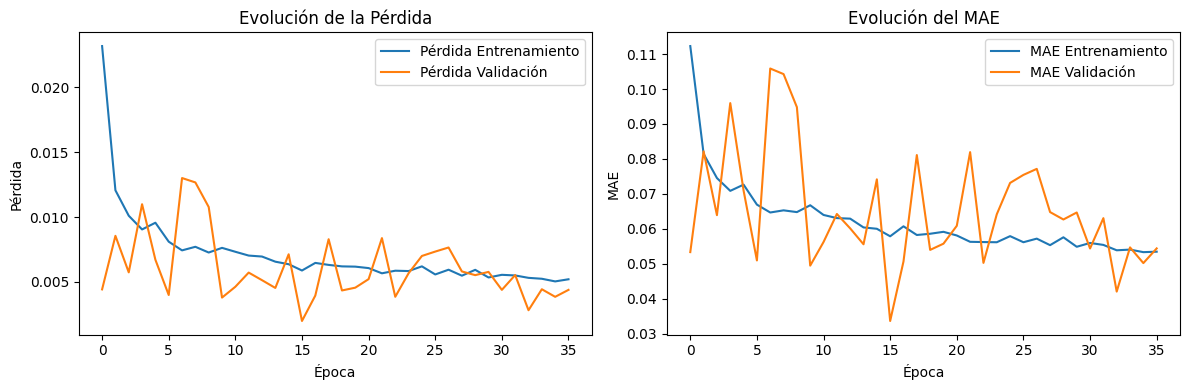

In [7]:
# Bloque 5: Entrenamiento del Modelo
print("🚀 Entrenando el modelo...")

# Callback para early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True
)

# Entrenar el modelo
historial = modelo.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping],
    verbose=1
)

print("✅ Entrenamiento completado!")

# Graficar el progreso del entrenamiento
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(historial.history['loss'], label='Pérdida Entrenamiento')
plt.plot(historial.history['val_loss'], label='Pérdida Validación')
plt.title('Evolución de la Pérdida')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(historial.history['mae'], label='MAE Entrenamiento')
plt.plot(historial.history['val_mae'], label='MAE Validación')
plt.title('Evolución del MAE')
plt.xlabel('Época')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluación del Modelo

📊 Evaluando el modelo...
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step 
📊 Métricas de Evaluación:
   - MAE (Error Absoluto Medio): 61.22 COP
   - MSE (Error Cuadrático Medio): 6577.28
   - RMSE (Raíz del Error Cuadrático Medio): 81.10 COP
   - Error Porcentual Medio: 1.47%
   - Rango de precios reales: 3851.14 - 4480.00 COP


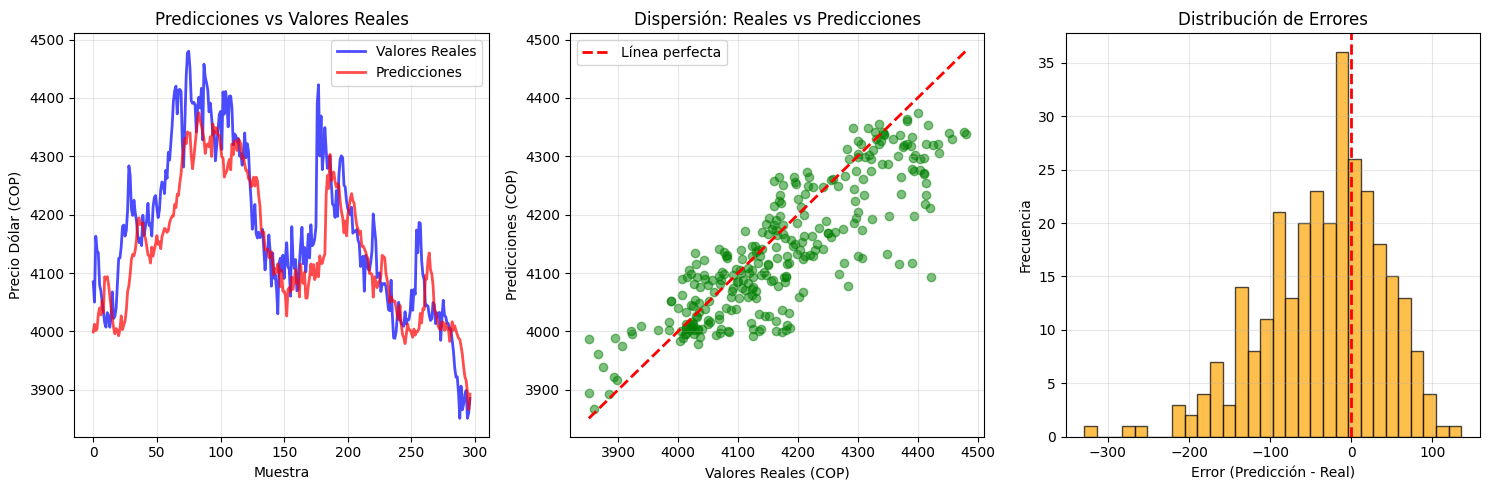


🔍 Ejemplos de predicciones (primeras 10 muestras):
Día | Real (COP) | Predicción (COP) | Error (COP)
-------------------------------------------------------
  1 |   4084.90 |   3999.07 |    -85.83
  2 |   4050.26 |   4012.33 |    -37.93
  3 |   4163.07 |   4001.51 |   -161.56
  4 |   4138.00 |   4004.47 |   -133.53
  5 |   4134.89 |   4030.22 |   -104.67
  6 |   4079.75 |   4040.24 |    -39.51
  7 |   4069.25 |   4028.34 |    -40.91
  8 |   4051.55 |   4052.69 |      1.14
  9 |   4035.22 |   4032.97 |     -2.25
 10 |   4014.75 |   4093.60 |     78.85


In [9]:
# Bloque 6 Corregido: Evaluación del Modelo
def evaluar_modelo(modelo, X_test, y_test, scaler_y):
    """
    Evalúa el modelo y muestra métricas de performance - CORREGIDO
    """
    # Asegurarse de que y_test esté en la forma correcta (2D) para inverse_transform
    y_test_2d = y_test.reshape(-1, 1) if len(y_test.shape) == 1 else y_test
    
    # Predecir con el modelo
    y_pred_normalizado = modelo.predict(X_test)
    
    # Convertir de vuelta a la escala original
    y_test_original = scaler_y.inverse_transform(y_test_2d)
    y_pred_original = scaler_y.inverse_transform(y_pred_normalizado)
    
    # Calcular métricas
    mae = mean_absolute_error(y_test_original, y_pred_original)
    mse = mean_squared_error(y_test_original, y_pred_original)
    rmse = np.sqrt(mse)
    
    # Calcular porcentaje de error
    error_porcentual = (mae / np.mean(y_test_original)) * 100
    
    print(f"📊 Métricas de Evaluación:")
    print(f"   - MAE (Error Absoluto Medio): {mae:.2f} COP")
    print(f"   - MSE (Error Cuadrático Medio): {mse:.2f}")
    print(f"   - RMSE (Raíz del Error Cuadrático Medio): {rmse:.2f} COP")
    print(f"   - Error Porcentual Medio: {error_porcentual:.2f}%")
    print(f"   - Rango de precios reales: {y_test_original.min():.2f} - {y_test_original.max():.2f} COP")
    
    # Graficar predicciones vs valores reales
    plt.figure(figsize=(15, 5))
    
    # Gráfico 1: Serie temporal
    plt.subplot(1, 3, 1)
    indices = range(len(y_test_original))
    plt.plot(indices, y_test_original, label='Valores Reales', alpha=0.7, linewidth=2, color='blue')
    plt.plot(indices, y_pred_original, label='Predicciones', alpha=0.7, linewidth=2, color='red')
    plt.title('Predicciones vs Valores Reales')
    plt.xlabel('Muestra')
    plt.ylabel('Precio Dólar (COP)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Gráfico 2: Dispersión
    plt.subplot(1, 3, 2)
    plt.scatter(y_test_original, y_pred_original, alpha=0.5, color='green')
    min_val = min(y_test_original.min(), y_pred_original.min())
    max_val = max(y_test_original.max(), y_pred_original.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Línea perfecta')
    plt.xlabel('Valores Reales (COP)')
    plt.ylabel('Predicciones (COP)')
    plt.title('Dispersión: Reales vs Predicciones')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Gráfico 3: Errores
    plt.subplot(1, 3, 3)
    errores = y_pred_original.flatten() - y_test_original.flatten()
    plt.hist(errores, bins=30, alpha=0.7, color='orange', edgecolor='black')
    plt.axvline(x=0, color='red', linestyle='--', linewidth=2)
    plt.title('Distribución de Errores')
    plt.xlabel('Error (Predicción - Real)')
    plt.ylabel('Frecuencia')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Mostrar algunas predicciones de ejemplo
    print(f"\n🔍 Ejemplos de predicciones (primeras 10 muestras):")
    print("Día | Real (COP) | Predicción (COP) | Error (COP)")
    print("-" * 55)
    for i in range(min(10, len(y_test_original))):
        real = y_test_original[i][0] if len(y_test_original[i].shape) > 0 else y_test_original[i]
        pred = y_pred_original[i][0] if len(y_pred_original[i].shape) > 0 else y_pred_original[i]
        error = pred - real
        print(f"{i+1:3d} | {real:9.2f} | {pred:9.2f} | {error:9.2f}")
    
    return y_test_original, y_pred_original

# Evaluar el modelo
print("📊 Evaluando el modelo...")
y_real, y_predicho = evaluar_modelo(modelo, X_test, y_test, scaler_y)

# Implementación de la Interfaz de Usuario

In [15]:
# Bloque 7 Corregido: Implementación de la Interfaz de Usuario
class PredictorDolar:
    def __init__(self, modelo, scaler_X, scaler_y, datos_historicos):
        self.modelo = modelo
        self.scaler_X = scaler_X
        self.scaler_y = scaler_y
        self.datos_historicos = datos_historicos
        self.ultimos_precios = datos_historicos['Close'].tail(10).values
    
    def predecir_dolar(self, precios_5_dias=None):
        """
        Predice el precio del dólar para una semana después - CORREGIDO
        """
        if precios_5_dias is None:
            # Usar los últimos 5 días disponibles
            precios_5_dias = self.ultimos_precios[-5:]
            print("💰 Usando últimos 5 días disponibles:")
            for i, precio in enumerate(precios_5_dias):
                # Convertir a float nativo de Python para formateo
                precio_float = float(precio)
                print(f"   Día {i+1}: {precio_float:.2f} COP")
        else:
            # Validar que se ingresen exactamente 5 precios
            if len(precios_5_dias) != 5:
                return "❌ Error: Debe ingresar exactamente 5 precios"
            
            precios_5_dias = np.array(precios_5_dias)
            print("💰 Precios ingresados:")
            for i, precio in enumerate(precios_5_dias):
                precio_float = float(precio)
                print(f"   Día {i+1}: {precio_float:.2f} COP")
        
        # Asegurarse de que es 2D para el scaler y convertir a float
        precios_5_dias_2d = precios_5_dias.reshape(1, -1).astype(float)
        
        # Normalizar los datos de entrada
        precios_normalizados = self.scaler_X.transform(precios_5_dias_2d)
        
        # Predecir
        prediccion_normalizada = self.modelo.predict(precios_normalizados)
        
        # Convertir a escala original (el scaler espera 2D)
        prediccion_2d = prediccion_normalizada.reshape(-1, 1)
        prediccion_original = self.scaler_y.inverse_transform(prediccion_2d)
        
        return float(prediccion_original[0][0])
    
    def mostrar_tendencia_actual(self):
        """
        Muestra la tendencia actual del dólar - CORREGIDO
        """
        ultimos_30_dias = self.datos_historicos['Close'].tail(30)
        
        plt.figure(figsize=(10, 6))
        plt.plot(ultimos_30_dias.index, ultimos_30_dias.values, marker='o', linewidth=2)
        plt.title('Tendencia del Dólar (Últimos 30 días)')
        plt.xlabel('Fecha')
        plt.ylabel('Precio (COP)')
        plt.grid(True, alpha=0.3)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
        
        cambio = ((ultimos_30_dias.iloc[-1] - ultimos_30_dias.iloc[0]) / ultimos_30_dias.iloc[0]) * 100
        precio_actual = float(ultimos_30_dias.iloc[-1])
        print(f"📈 Cambio en los últimos 30 días: {cambio:+.2f}%")
        print(f"💵 Precio actual: {precio_actual:.2f} COP")
        return precio_actual

# Crear el predictor
predictor = PredictorDolar(modelo, scaler_X, scaler_y, datos_dolar)

# Interfaz Interactiva

🚀 Iniciando interfaz de predicción del dólar...
🤖 PREDICTOR DEL PRECIO DEL DÓLAR (TRM)

Opciones:
1. 🎯 Predecir con últimos 5 días disponibles
2. ⌨️  Ingresar manualmente 5 precios
3. 📊 Ver tendencia actual
4. ❌ Salir


💰 Usando últimos 5 días disponibles:
   Día 1: 3898.90 COP
   Día 2: 3851.20 COP
   Día 3: 3860.25 COP
   Día 4: 3885.24 COP
   Día 5: 3900.25 COP
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


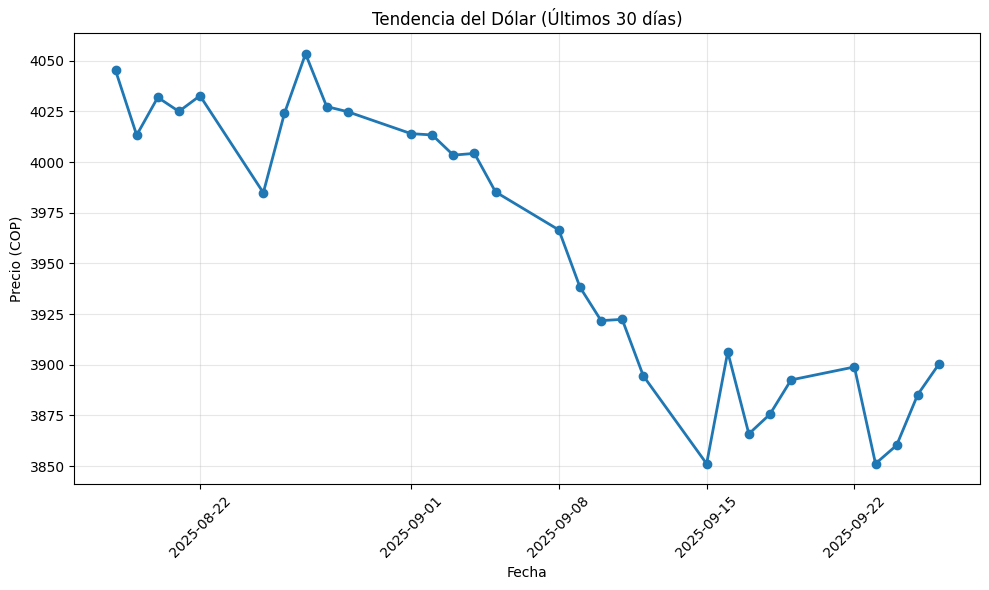

❌ Error en la predicción: unsupported format string passed to Series.__format__
⚠️ Intentando con datos de ejemplo...
💰 Precios ingresados:
   Día 1: 3800.50 COP
   Día 2: 3815.25 COP
   Día 3: 3820.75 COP
   Día 4: 3810.30 COP
   Día 5: 3825.60 COP
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
🔮 Predicción con datos de ejemplo: 3827.63 COP

Opciones:
1. 🎯 Predecir con últimos 5 días disponibles
2. ⌨️  Ingresar manualmente 5 precios
3. 📊 Ver tendencia actual
4. ❌ Salir
👋 ¡Gracias por usar el Predictor del Dólar!


In [16]:
# Bloque 8 Corregido: Interfaz Interactiva
def interfaz_usuario():
    """
    Interfaz interactiva para que el usuario ingrese datos y obtenga predicciones - CORREGIDO
    """
    print("=" * 60)
    print("🤖 PREDICTOR DEL PRECIO DEL DÓLAR (TRM)")
    print("=" * 60)
    
    while True:
        print("\nOpciones:")
        print("1. 🎯 Predecir con últimos 5 días disponibles")
        print("2. ⌨️  Ingresar manualmente 5 precios")
        print("3. 📊 Ver tendencia actual")
        print("4. ❌ Salir")
        
        opcion = input("\nSeleccione una opción (1-4): ").strip()
        
        if opcion == '1':
            try:
                # Predicción con últimos 5 días
                prediccion = predictor.predecir_dolar()
                precio_actual = predictor.mostrar_tendencia_actual()
                
                cambio_predicho = ((prediccion - precio_actual) / precio_actual) * 100
                
                print(f"\n🔮 PREDICCIÓN PARA UNA SEMANA DESPUÉS: {prediccion:.2f} COP")
                print(f"💵 Precio actual: {precio_actual:.2f} COP")
                print(f"📊 Cambio predicho: {cambio_predicho:+.2f}%")
                
                # Interpretación del resultado
                if cambio_predicho > 2:
                    print("📈 Tendencia: FUERTE ALZA esperada")
                elif cambio_predicho > 0.5:
                    print("📈 Tendencia: ALZA moderada esperada")
                elif cambio_predicho < -2:
                    print("📉 Tendencia: FUERTE BAJA esperada")
                elif cambio_predicho < -0.5:
                    print("📉 Tendencia: BAJA moderada esperada")
                else:
                    print("➡️ Tendencia: ESTABLE (poca variación esperada)")
                    
            except Exception as e:
                print(f"❌ Error en la predicción: {e}")
                print("⚠️ Intentando con datos de ejemplo...")
                # Datos de ejemplo de respaldo
                precios_ejemplo = [3800.50, 3815.25, 3820.75, 3810.30, 3825.60]
                prediccion = predictor.predecir_dolar(precios_ejemplo)
                print(f"🔮 Predicción con datos de ejemplo: {prediccion:.2f} COP")
            
        elif opcion == '2':
            try:
                # Ingreso manual de precios
                print("\n💵 Ingrese los precios del dólar de 5 días consecutivos:")
                precios_manuales = []
                
                for i in range(5):
                    while True:
                        try:
                            precio_str = input(f"Precio día {i+1} (COP): ").replace(',', '.')
                            precio = float(precio_str)
                            if precio > 0:
                                precios_manuales.append(precio)
                                break
                            else:
                                print("❌ El precio debe ser mayor a 0")
                        except ValueError:
                            print("❌ Ingrese un número válido (ej: 3850.75)")
                
                prediccion = predictor.predecir_dolar(precios_manuales)
                precio_promedio = float(np.mean(precios_manuales))
                cambio_predicho = ((prediccion - precio_promedio) / precio_promedio) * 100
                
                print(f"\n🔮 PREDICCIÓN PARA UNA SEMANA DESPUÉS: {prediccion:.2f} COP")
                print(f"💵 Precio promedio ingresado: {precio_promedio:.2f} COP")
                print(f"📊 Cambio predicho: {cambio_predicho:+.2f}%")
                
            except Exception as e:
                print(f"❌ Error en el ingreso de datos: {e}")
            
        elif opcion == '3':
            # Mostrar tendencia
            try:
                predictor.mostrar_tendencia_actual()
            except Exception as e:
                print(f"❌ Error mostrando tendencia: {e}")
            
        elif opcion == '4':
            print("👋 ¡Gracias por usar el Predictor del Dólar!")
            break
            
        else:
            print("❌ Opción no válida. Por favor, seleccione 1-4.")
        
        # Pausa antes de mostrar el menú nuevamente
        input("\nPresione Enter para continuar...")

# Ejecutar la interfaz
print("🚀 Iniciando interfaz de predicción del dólar...")
interfaz_usuario()